In [6]:
####### ---- This notebook is for playing around with and understanding the inner workings of what is going on in the code. It is not abstracted. ---- #######

In [7]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():  
    dev = torch.device("cuda:0")
else:
    dev = torch.device("cpu")

print(f"Using {dev}")

Using cuda:0


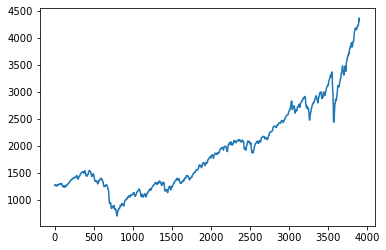

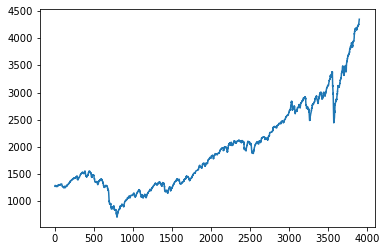

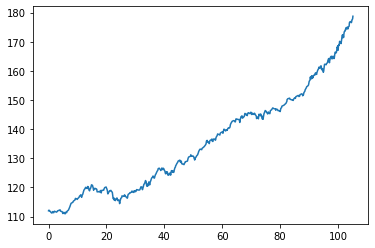

In [8]:
# ---- data loading and pre-processing ---- #

import utils.polar_pla as pla
import numpy as np
import torch
from torch.autograd import Variable

torch.set_default_tensor_type('torch.cuda.FloatTensor')
# read in time series into temporary list
series = []
f = open('DataSets/snp500.csv', 'r')
for line in f:
    series.append(float(line))

# median filter the time series
filtered_series = pla.median_filter(series, 10)

# run bottom up piecewise linear approximation on that list and store processed values
data, max_len = pla.sliding_window_pla(filtered_series,10)

pla.display_trends(data, 112) # this will show a messy reconstruction of the data as if it were interpolated

# set the sequence length (the number of trends we look at to predict the next) and the train to test ratio
seq_length = 8
train_proportion = 0.7

# segment the data into input output pairs that we will use to train the model. The way we do this depends on the model type.
def sliding_window_MLP(data):
    inputs = []
    outputs = []
    for i in range(0, len(data)-seq_length*2, 2):
        inputs.append(data[i:(i+seq_length*2)]) # the next n are the input
        outputs.append(data[i+seq_length*2:i+seq_length*2+1]) # and the one after that is the output
    return Variable(torch.cuda.FloatTensor(np.array(inputs)).to(dev)), Variable(torch.cuda.FloatTensor(np.array(outputs)).to(dev))

def sliding_window_CNN(data):
    inputs = []
    outputs = []
    for i in range(0, len(data)-seq_length*2, 2):
        temp = data[i:(i+seq_length*2)]
        new = []
        for x in range(0,len(temp),2):
            new.append([temp[x],temp[x+1]])
        inputs.append(new)
        outputs.append(data[i+seq_length*2:i+seq_length*2+1]) # and the one after that is the output
    return Variable(torch.cuda.FloatTensor(np.array(inputs)).to(dev)), Variable(torch.cuda.FloatTensor(np.array(outputs)).to(dev))

def sliding_window_RNN(data):
    inputs = []
    outputs = []
    for i in range(0, len(data)-seq_length*2, 2):
        inputs.append(np.array(data[i:(i+seq_length*2)]).reshape(int(seq_length*2/2),2))
        outputs.append(np.array(data[i+seq_length*2+1:i+seq_length*2+2]))
    return Variable(torch.cuda.FloatTensor(inputs).to(dev)), Variable(torch.cuda.FloatTensor(outputs).to(dev))

# convert data to tensor, and apply dataloader
total_data_input, total_data_output = sliding_window_MLP(data)
train_size = int(len(total_data_input)*train_proportion)

training_data_input = torch.narrow(total_data_input, 0, 0, train_size)
training_data_output = torch.narrow(total_data_output, 0, 0, train_size)

validation_index = int((len(total_data_input) - train_size)*0.5) #Calculates how many data points in the validation set
testing_index = len(total_data_input) - train_size - validation_index

validation_data_input = torch.narrow(total_data_input, 0, train_size, validation_index).to(dev)
validation_data_output = torch.narrow(total_data_output, 0, train_size, validation_index).to(dev)

testing_data_input = torch.narrow(total_data_input, 0, train_size+validation_index, testing_index).to(dev)
testing_data_output = torch.narrow(total_data_output, 0, train_size+validation_index, testing_index).to(dev)

train = torch.utils.data.TensorDataset(training_data_input, training_data_output)
validate = torch.utils.data.TensorDataset(validation_data_input, validation_data_output)
test = torch.utils.data.TensorDataset(testing_data_input, testing_data_output)

trainset = torch.utils.data.DataLoader(train, batch_size=128, shuffle=False)
validateset = torch.utils.data.DataLoader(validate, batch_size=128, shuffle=False)
testset = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

In [9]:
from models import MLP, TCN, CNN, RNN, LSTM, BiLSTM
#model = MLP(seq_length*2, 128, 0.1).to(dev)
#model = CNN(seq_length, 64, 1,0.3,2).to(dev)
#model = TCN(seq_length,1, [64]*3,4,0.2).to(dev)
#model = LSTM(1,2,64,1,0.5)
#model = RNN(1,2,64,1,0.3)
#print(model)

In [10]:
testing_file = open('test.txt', 'w')
import math
import statistics
res = []
total_dir_acc = 0
for i in range(10):
    model = MLP(seq_length*2, 128, 1, 0.1).to(dev)#TCN(seq_length,1, [128]*4,4,0.2).to(dev)
    epochs = 10
    learning_rate = 0.001
    import torch.optim as optim
    train_loss = []
    validation_loss = []
    model.train()
    epoch_total_trainloss = 0 # the total loss for each epoch, used for plotting
    min_val_loss_epoch = 0 # the epoch with the lowest validation loss
    min_val_loss = 9999999 # the lowest validation loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    validation_direction_accuracy = []

    for epoch in range(epochs+1):

        epoch_total_trainloss = 0 # reset this for the validation epoch'''
        model.train()
        for data in trainset:  # for each batch
            features, labels = data  # split the batches up into their features and labels
            model.zero_grad()
            output = model(features) # get a prediction from the model
            #print(output.shape)
            loss = F.mse_loss(output, labels)  # calculate the loss of our prediction
            loss.backward()  # backpropogate the loss
            optimizer.step()  # optimize weights
            epoch_total_trainloss += loss.item()/len(trainset)
            torch.cuda.synchronize()
        train_loss.append(epoch_total_trainloss) # add this epoch's loss in order to plot it later
        epoch_total_trainloss = 0 # reset this for the validation epoch

        # now we'll calculate the direction accuracy for the training and validation sets
        correct=0
        total_points = 0
        model.eval()
        for data in validateset:
            
            inputs, labels = data
            output = model(inputs)
            total_points += len(output)
            for i in range(len(output)):
                pred = output[i]
                actual = labels[i]
                #if pred < 0 and actual < 0 or pred > 0 and actual > 0: #or (pred-actual)<0.01:
                #    correct += 1
                #print(output[0],labels[0])
            loss = F.mse_loss(output, labels)  # calculate the loss of our prediction
            epoch_total_trainloss += loss.item()/len(validateset)
            torch.cuda.synchronize()
        if epoch_total_trainloss < min_val_loss:
            torch.save(model.state_dict(), 'temp.pt')
            min_val_loss = epoch_total_trainloss
            min_val_loss_epoch = epoch
        validation_direction_accuracy.append(correct/(total_points))
        validation_loss.append(epoch_total_trainloss) # we'll need to plot validation loss too
    #import matplotlib.pyplot as plt
    #plt.plot(train_loss)
    #plt.plot(validation_loss)
    #plt.show()
    #plt.plot(validation_direction_accuracy)
    #plt.show()
    #print(f"Lowest validation loss: {min_val_loss} at epoch {min_val_loss_epoch}")

    model.load_state_dict(torch.load('temp.pt'))
    model.eval()
    correct=0
    output_file = open("utils/angles.txt", "w")
    for data in trainset:

        inputs, labels = data
        output = model(inputs)
        for i in range(len(output)):
            pred = output[i]
            #output_file.write(str(pred.item()*90)+"\n")
    total_loss = 0
    for data in validateset:
        inputs, labels = data
        output = model(inputs)
        #for i in range(len(output)):
            #pred = output[i]
            #actual = labels[i]
            #if pred < 0 and actual < 0 or pred > 0 and actual > 0:
            #    correct += 1
        model.zero_grad()
        total_loss += F.mse_loss(output, labels).item()/len(validateset)
    #print(f'Directional Accuracy: {correct*100/len(test)} MSE on validate set: {total_loss}')

    total_loss = 0
    total_loss_slope = 0
    total_loss_length = 0

    for data in testset:
        inputs, labels = data
        output = model(inputs)
        '''
        output_slopes = []
        for out in labels:
            output_slopes.append(np.array([out[0]]))
        output_slopes = Variable(torch.FloatTensor(output_slopes))

        output_lengths = []
        for out in labels:
            output_lengths.append(np.array([out[1]]))
        output_lengths = Variable(torch.FloatTensor(output_lengths))

        pred_slopes = []
        for out in output:
            pred_slopes.append(np.array([out[0]]))
        pred_slopes = Variable(torch.FloatTensor(pred_slopes))

        pred_lengths = []
        for out in output:
            pred_lengths.append(np.array([out[1]]))
        pred_lengths = Variable(torch.FloatTensor(pred_lengths))
        '''
        for i in range(len(output)):
            pred = output[i]#[0]
            actual = labels[i]#[0]
            if pred < 0 and actual < 0 or pred > 0 and actual > 0:
                #print(str(pred)+" vs "+str(actual))
                correct += 1
            output_file.write(str(pred.item()*90)+"\n")
        model.zero_grad()
        total_loss += F.mse_loss(output, labels).item()/len(testset)
        #total_loss_slope += F.mse_loss(output_slopes,pred_slopes).item()/len(testset)
        #model.zero_grad()
        #total_loss_length += F.mse_loss(output_lengths, pred_lengths).item()/len(testset)
    total_dir_acc += correct*100/len(test)
    #print(f'Directional Accuracy: {correct*100/len(test)} MSE test: {total_loss}, RMSE test: {math.sqrt(total_loss)}\n')
    res.append(math.sqrt(total_loss))
    #print(f'{math.sqrt(total_loss_slope)}, {math.sqrt(total_loss_length)}')
    #testing_file.write(f'{math.sqrt(total_loss_slope)},{math.sqrt(total_loss_length)}\n')
    print(f'{math.sqrt(total_loss)}')
    testing_file.write(f'{math.sqrt(total_loss)}\n')
print(f'μ = {round(sum(res) / len(res ),3)} | σ = {round(statistics.pstdev(res),3)} | dir = {total_dir_acc/10}')
testing_file.close()

0.5679438405825361
0.5675195867250455
0.567256539191512
0.5715312868108158
0.5735198458137044
0.5782262868047281
0.5708172667694962
0.5717020091034699
0.5711072844481424
0.5730918804196241
μ = 0.571 | σ = 0.003 | dir = 84.25806451612904


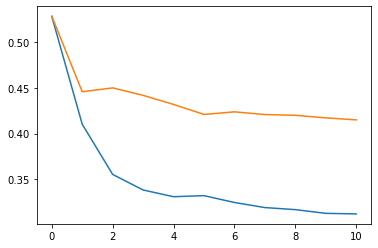

Directional Accuracy: 80.64516129032258 MSE on validate set: 0.41500918567180634
Directional Accuracy: 165.16129032258064 MSE test: 0.3284343034029007, RMSE test: 0.5730918804196241


In [11]:
# test
import math
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()
'''
with torch.no_grad():
    correct = 0
    i = 0
    X, Y = [], []
    X2, Y2 = [], []
    total_loss = 0
    output_file = open("angles.txt", "w")
    for data in train:
        print(len(data))
        inputs, labels = data
        output = model(inputs)
        output_file.write(str(output.item()*90) + "\n")
        model.zero_grad()

    for data in test:
        inputs, labels = data
        output = model(inputs)
        output_file.write(str(output.item()*90) + "\n")
        model.zero_grad()
        total_loss += F.mse_loss(output[0], labels).item()
        output = output[0]
        if output[0] < 0 and labels[0] < 0 or output[0] > 0 and labels[0] > 0:
            correct += 1
            #print(output[0],labels[0])
    print(f'Directional Accuracy: {correct*100/len(test)}, Average Loss: {total_loss/len(test)}')
'''

# test
model.load_state_dict(torch.load('temp.pt'))
model.eval()
correct=0
output_file = open("utils/angles.txt", "w")
for data in trainset:

    inputs, labels = data
    output = model(inputs)
    for i in range(len(output)):
        pred = output[i]
        output_file.write(str(pred.item()*90)+"\n")
total_loss = 0
for data in validateset:
    inputs, labels = data
    output = model(inputs)
    for i in range(len(output)):
        pred = output[i]
        actual = labels[i]
        if pred < 0 and actual < 0 or pred > 0 and actual > 0:
            correct += 1
    model.zero_grad()
    total_loss += F.mse_loss(output, labels).item()/len(validateset)
print(f'Directional Accuracy: {correct*100/len(test)} MSE on validate set: {total_loss}')

correct = 0
total_loss = 0
for data in testset:
    inputs, labels = data
    output = model(inputs)
    for i in range(len(output)):
        pred = output[i]
        actual = labels[i]
        if pred < 0 and actual < 0 or pred > 0 and actual > 0:
            #print(str(pred)+" vs "+str(actual))
            correct += 1
        output_file.write(str(pred.item()*90)+"\n")
    model.zero_grad()
    total_loss += F.mse_loss(output, labels).item()/len(testset)
print(f'Directional Accuracy: {correct*100/len(test)} MSE test: {total_loss}, RMSE test: {math.sqrt(total_loss)}')

